In [1]:
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from monotonenorm import GroupSort, direct_norm, SigmaNet
# pip install -e . in the directory with setup.py if you do not have monotonenorm installed
plt.style.use('mpl-config')

We will make a simple toy regression model to fit the following 1D function $$f(x) = \log(x) + \epsilon(x)$$
where $\epsilon$ is a gaussian noise term whose variance is linearly increasing in x. 
In this toy model we will assume that we have good reason to believe that the function we are trying to fit is monotonic (despite non-monotnic behavior of the noise). For example, we are building a trigger algorithm to discriminate between signal and background events. Rarer events are more likely to be signal and thus we should employ a network which is monotonic in some "rareness" feature. Another example could be a hiring classifier where (all else equal) higher school grades should imply better chances of being hired. 

Now we will fit an unconstrained model and monotonic Lipschitz model.

In [2]:
class UnconstrainedModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.LazyBatchNorm1d(affine=False),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, 16),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(16, 1),
)
    def forward(self, x):
        return self.model(x)

# Build a Lipschitz-1 network
class RobustModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            direct_norm(torch.nn.Linear(1, 16), kind="one-inf"),
            GroupSort(2),
            direct_norm(torch.nn.Linear(16, 16), kind="inf"),
            GroupSort(2),
            direct_norm(torch.nn.Linear(16, 16), kind="inf"),
            GroupSort(2),
            direct_norm(torch.nn.Linear(16, 1), kind="inf"),
        )
        for name, param in self.named_parameters():
            if 'weight' in name:
                if "model.0" in name:
                    param.data  =  - torch.ones_like(param.data)
                else:
                    param.data  =  torch.eye(*param.shape) + torch.randn_like(param.data) * 0.001

    def forward(self, x):
        return self.model(x)

In [3]:
# Config
EPOCHS = 20000
N = 30           # Number of points 
loss_func = torch.nn.MSELoss()

In [4]:
up = True
interp = True
y_list_fname = f"y_list_monotonicExample-Up{up}-Interp{interp}.pt"
y_robust_list_fname = f"y_robust_list_monotonicExample-Up{up}-Interp{interp}.pt"
# simple toy data
def gen_data(interp=False, up=False):
    seed = 2 if up else 16 
    torch.manual_seed(seed)
    max_range = 3   # Maximum range of x
    if interp == False:
        x_train = torch.linspace(1, max_range, N).view(-1, 1)
    else:
        x_train = torch.linspace(1, max_range, N//2).view(-1, 1)
        x_train = torch.cat([x_train, torch.linspace(1.5, 2, N//2).view(-1,1) * max_range], dim=0)
    true_model = lambda x: torch.log(x)
    y_train = true_model(x_train)
    # Adding linearly increasing noise
    y_error = torch.linspace(0.01, 0.3, N).view(-1, 1) 
    noise = torch.randn(N).view(-1, 1) * y_error
    y_train -= noise

    # PLOT DATA
    x_linspace = torch.linspace(1, max_range * 2, 2 * N).view(-1, 1)
    y_linspace = true_model(x_linspace)
    return x_train, y_train, x_linspace, y_linspace, y_error
x_train, y_train, x_linspace, y_linspace, y_error = gen_data(interp=interp, up=up)

In [123]:
y_list = []
y_robust_list = []
torch.manual_seed(0)
for i in range(10):
    model = UnconstrainedModel()
    monotonic_model = SigmaNet(RobustModel())
    # optim = torch.optim.Adam([{"params" : model.parameters()}, {"params" : monotonic_model.parameters()}], lr=2e-3)
    optim = torch.optim.Adam([{"params" : model.parameters()}, {"params" : monotonic_model.parameters()}], lr=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=5e-3, total_steps=EPOCHS)

    # Train both models at the same time
    pbar = tqdm(range(EPOCHS))
    for i in pbar:
        y = model(x_train)
        y_robust = monotonic_model(x_train)
        loss = loss_func(y, y_train)
        loss_robust = loss_func(y_robust, y_train)
        loss_robust.backward()
        loss.backward()
        optim.step()
        scheduler.step()
        optim.zero_grad()
        pbar.set_description(
            f"epoch: {i} loss: {loss.item():.4f}, loss_robust: {loss_robust.item():.4f}")
        # Plot results
    with torch.no_grad():
        model.eval()
        y = model(x_linspace)
        y_robust = monotonic_model(x_linspace)
        y_list.append(y)
        y_robust_list.append(y_robust)

/home/kitouni/miniconda3/envs/main/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [124]:
# save lists
torch.save(y_list, y_list_fname)
torch.save(y_robust_list, y_robust_list_fname)

In [14]:
# load lists
up = False
interp = False
y_list_fname = f"y_list_monotonicExample-Up{up}-Interp{interp}.pt"
y_robust_list_fname = f"y_robust_list_monotonicExample-Up{up}-Interp{interp}.pt"
y_list = torch.load(y_list_fname)
y_robust_list = torch.load(y_robust_list_fname)
x_train, y_train, x_linspace, y_linspace, y_error = gen_data(interp=interp, up=up)

Saved monotonic_dependence_unobserved_UpFalse_InterpFalse.pdf


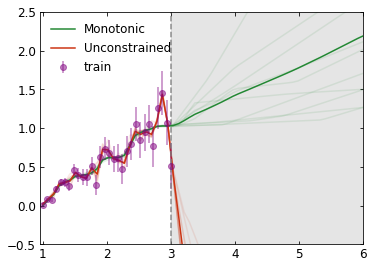

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), dpi=200)
for y, y_robust in zip(y_list, y_robust_list):
    ax.plot(x_linspace.numpy(), y_robust.numpy(), color='C1', alpha=0.1)
    ax.plot(x_linspace.numpy(), y.numpy(), color='C2', alpha=0.1)
# plot mean
ax.plot(x_linspace.numpy(), torch.hstack(y_robust_list).mean(1).numpy(), color='C1', label='Monotonic')
ax.plot(x_linspace.numpy(), torch.hstack(y_list).mean(1).numpy(), color='C2', label='Unconstrained')

# plt.plot(x_linspace, y_linspace, c='gray',
#          linestyle='--', alpha=0.9, label="true function")
plt.errorbar(x_train.numpy().flatten(), y_train.numpy().flatten(), 
    yerr=y_error.numpy().flatten(), fmt='o', c='purple', label='train', alpha=0.5)
plt.legend(loc='upper left')
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(1-0.05,6)
if interp:
    ax.axvline(3, c='gray', linestyle='--', alpha=0.9)
    ax.axvline(4.5, c='gray', linestyle='--', alpha=0.9)
    ax.fill_betweenx([-0.5, 2.5], 3, 4.5, color='gray', alpha=0.2)
else:
    ax.axvline(3, c='gray', linestyle='--', alpha=0.9)
    ax.fill_betweenx([-2, 3], 3, 6, color='gray', alpha=0.2)
figname = f"monotonic_dependence_unobserved_Up{up}_Interp{interp}.pdf"
plt.tight_layout(pad=0)
plt.savefig(figname)
print("Saved", figname)
plt.show()

Now we will make a different toy model with one noisy data point. This will show that the Lipschitz continuous network is more robust against outliers than an unconstrained network because its gradient with respect to the input is bounded between -1 and 1. Additionally, it is more robust against adversarial attacks/data corruption for the same reason.

In [49]:
def gen_data2():
    torch.manual_seed(4)
    x_train = torch.linspace(-3, 3, N).view(-1, 1)

    y_train_error = torch.ones(N).view(-1, 1) * 0.05
    y_train_error[N // 2] = 1
    y_train = torch.sin(x_train) + torch.randn(N).view(-1, 1) * y_train_error

    # PLOT DATA
    x_linspace = torch.linspace(-3, 3, 2 * N).view(-1, 1)
    y_linspace = torch.sin(x_linspace)
    return x_train, y_train, x_linspace, y_linspace, y_train_error
x_train, y_train, x_linspace, y_linspace, y_error = gen_data2()

In [53]:
# Now we will make a simple function
# Nice seed for the noisy point
N = 30
EPOCHS = 50000
loss_func = torch.nn.L1Loss(reduction='none')



y_list = []
y_robust_list = []
for _ in range(10):
    pbar = tqdm(range(EPOCHS))
    model = UnconstrainedModel()
    robust_model = RobustModel()
    optim = torch.optim.Adam([{"params" : model.parameters()}, {"params" : robust_model.parameters()}], lr=1e-3, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=5e-3, total_steps=EPOCHS)
    for i in pbar:
        # batch_indices = torch.randint(0, N, (32, )) 
        # x_batch = x_train[batch_indices]
        # y_batch = y_train[batch_indices]
        y = model(x_train)
        y_robust = robust_model(x_train)
        loss = torch.mean(loss_func(y, y_train))
        loss_robust = torch.mean(loss_func(y_robust, y_train))# * weights_batch)
        loss_robust.backward()
        loss.backward()
        optim.step()
        scheduler.step()
        optim.zero_grad()
        pbar.set_description(
            f"epoch: {i} loss: {loss.item():.4f}, loss_robust: {loss_robust.item():.4f}")

    with torch.no_grad():
        y = model(x_linspace)
        y_robust = robust_model(x_linspace)
        y_list.append(y)
        y_robust_list.append(y_robust)
# save lists
torch.save(y_list, "y_list_robustExample.pt")
torch.save(y_robust_list, "y_robust_list_robustExample.pt")

  0%|          | 0/50000 [00:00<?, ?it/s]

/home/kitouni/miniconda3/envs/main/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Saved robust_against_noisy_outlier_3.pdf


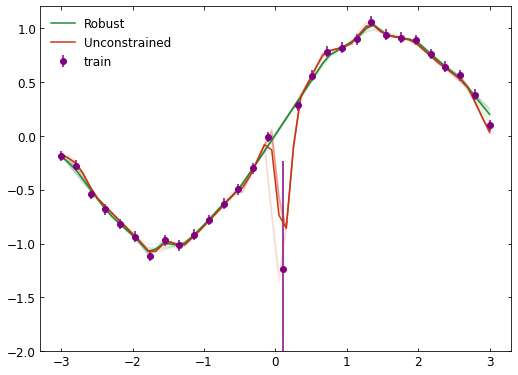

In [54]:
# load lists
y_list = torch.load("y_list_robustExample.pt")
y_robust_list = torch.load("y_robust_list_robustExample.pt")

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.errorbar(x_train.numpy().flatten(), y_train.numpy().flatten(), yerr=y_error.numpy().flatten(), fmt='o', c='purple', label='train')
for y, y_robust in zip(y_list, y_robust_list):
    ax.plot(x_linspace.numpy(), y_robust.numpy(), color='C1', alpha=0.1)
    ax.plot(x_linspace.numpy(), y.numpy(), color='C2', alpha=0.1)
# plot mean
ax.plot(x_linspace.numpy(), torch.hstack(y_robust_list).mean(1).numpy(), color='C1', label='Robust')
ax.plot(x_linspace.numpy(), torch.hstack(y_list).mean(1).numpy(), color='C2', label='Unconstrained')

# plt.plot(x_linspace, y_linspace, c='gray',
        #  linestyle='--', alpha=0.9, label="true function")
plt.legend()
figname = "robust_against_noisy_outlier_3.pdf"
plt.ylim(-2, 1.2)
plt.tight_layout(pad=0)
plt.savefig(figname)
print("Saved", figname)
plt.show()